In [1]:
import torch
from PIL import Image
import IPython
from utils import draw_landmarks_on_image

HEIGHT, WIDTH = 480, 848
import numpy as np

In [2]:
h1 = [0.3996416926383972, 0.8413947820663452, 3.581182284051465e-07, 0.37495410442352295, 0.7088689804077148, 0.006695433519780636, 0.3964425325393677, 0.595902144908905, 0.009547620080411434, 0.4379405975341797, 0.5500255823135376, 0.010947623290121555, 0.4693464934825897, 0.5369591116905212, 0.012689052149653435, 0.41608479619026184, 0.5367227792739868, -0.008178960531949997, 0.42339926958084106, 0.384441614151001, -0.014541585929691792, 0.430178165435791, 0.2937583029270172, -0.017104003578424454, 0.4379025399684906, 0.22585943341255188, -0.018291667103767395, 0.46063971519470215, 0.5693675875663757, -0.014050980098545551, 0.49313512444496155, 0.4442290961742401, -0.01715371198952198, 0.5165508985519409, 0.37713685631752014, -0.017738977447152138, 0.5377882122993469, 0.3325599133968353, -0.017881829291582108, 0.49112242460250854, 0.6179909110069275, -0.01814105361700058, 0.5034812092781067, 0.5287481546401978, -0.021909624338150024, 0.48333126306533813, 0.5404998660087585, -0.01794051006436348, 0.4671288728713989, 0.5711888670921326, -0.012892799451947212, 0.5075646638870239, 0.6675828099250793, -0.02160152979195118, 0.5010015368461609, 0.5938652157783508, -0.024522799998521805, 0.48198196291923523, 0.5992310643196106, -0.017849650233983994, 0.4714977443218231, 0.6254611611366272, -0.010133002884685993]
h2 = [0.35533082485198975, 0.6564074754714966, -2.8033653620695986e-07, 0.3760698735713959, 0.5366362929344177, -0.0006140012992545962, 0.4098513126373291, 0.4288856089115143, -0.012530672363936901, 0.4314376711845398, 0.3418208658695221, -0.025518521666526794, 0.4298466145992279, 0.2656515836715698, -0.035403527319431305, 0.47643208503723145, 0.4315398335456848, -0.020241491496562958, 0.5407770276069641, 0.4868505597114563, -0.03159497678279877, 0.5186852812767029, 0.5139272212982178, -0.036152709275484085, 0.49170711636543274, 0.5069488286972046, -0.03960372507572174, 0.4839446246623993, 0.5011927485466003, -0.03113446943461895, 0.5468834638595581, 0.5546752214431763, -0.03294254094362259, 0.5227102041244507, 0.5767126679420471, -0.02781817689538002, 0.4950627386569977, 0.5703692436218262, -0.027935119345784187, 0.485193133354187, 0.5800006985664368, -0.04157782718539238, 0.5396433472633362, 0.6268636584281921, -0.04040025174617767, 0.5149098634719849, 0.6403869986534119, -0.027082422748208046, 0.48809614777565, 0.6312093734741211, -0.022718509659171104, 0.48180699348449707, 0.6592884063720703, -0.05248719081282616, 0.5215261578559875, 0.6895438432693481, -0.048782095313072205, 0.4970412850379944, 0.6940376162528992, -0.0353999100625515, 0.4740889072418213, 0.6822585463523865, -0.027899114415049553]
h1 = torch.tensor(h1).reshape(-1, 3)
h2 = torch.tensor(h2).reshape(-1, 3)
batch = torch.stack([h1, h2])
print(batch.shape)

torch.Size([2, 21, 3])


In [3]:
def rotate_points(points: torch.Tensor, max_angle: int) -> torch.Tensor:  
    batch_size = points.shape[0]

    angle_x = torch.deg2rad(torch.randint(-max_angle, max_angle, (batch_size, 1)))
    angle_y = torch.deg2rad(torch.randint(-max_angle, max_angle, (batch_size, 1)))
    angle_z = torch.deg2rad(torch.randint(-max_angle//2, max_angle//2, (batch_size, 1)))
    
    cos_x, sin_x = torch.cos(angle_x), torch.sin(angle_x)
    cos_y, sin_y = torch.cos(angle_y), torch.sin(angle_y)
    cos_z, sin_z = torch.cos(angle_z), torch.sin(angle_z)
    ones = torch.ones((batch_size, 1))
    zeros = torch.zeros((batch_size, 1))
    
    Rx = torch.cat([ones, zeros, zeros,
                    zeros, cos_x, -sin_x,
                    zeros, sin_x, cos_x], dim=1).reshape(batch_size, 3, 3)

    Ry = torch.cat([cos_y, zeros, sin_y,
                    zeros, ones, zeros,
                    -sin_y, zeros, cos_y], dim=1).reshape(batch_size, 3, 3)

    Rz = torch.cat([cos_z, -sin_z, zeros,
                    sin_z, cos_z, zeros,
                    zeros, zeros, ones], dim=1).reshape(batch_size, 3, 3)

    return torch.matmul(torch.matmul(torch.matmul(points, Rz), Ry), Rx)


In [4]:
def normalize_landmarks(landmarks: torch.Tensor) -> torch.Tensor:
    mean_vals = torch.mean(landmarks, dim=1, keepdim=True)
    std_vals = torch.std(landmarks, dim=1, keepdim=True) + 1e-8  # Add small epsilon for stability
    
    return (landmarks - mean_vals) / std_vals


In [5]:
def horizontal_flip(landmarks: torch.Tensor) -> torch.Tensor:
    return landmarks * torch.tensor([-1, 1, 1], dtype=landmarks.dtype)

def depth_flip(landmarks: torch.Tensor) -> torch.Tensor:
    return landmarks * torch.tensor([1, 1, -1], dtype=landmarks.dtype)

In [6]:
def plot_hands(batch, w=WIDTH, h=HEIGHT):
    for i in range(batch.shape[0]):
        hand = batch[i]
        frame = np.zeros((h, w, 3), dtype=np.uint8)
        frame = draw_landmarks_on_image(frame, hand)
        IPython.display.display(Image.fromarray(frame))

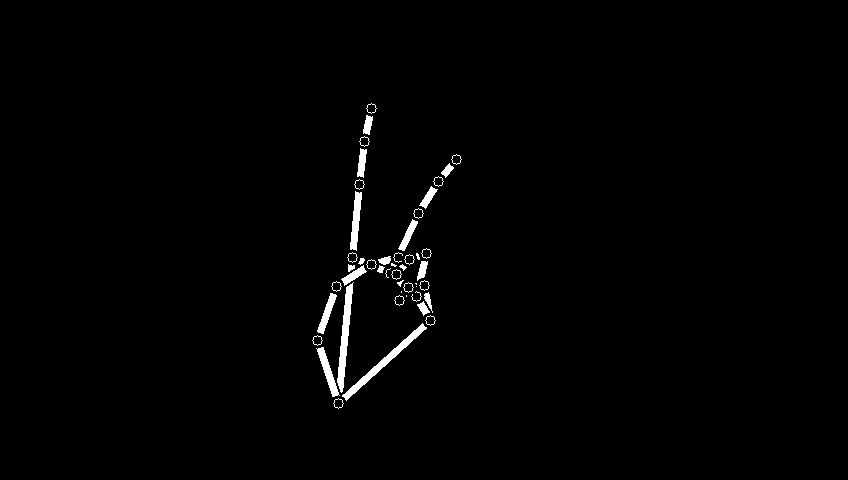

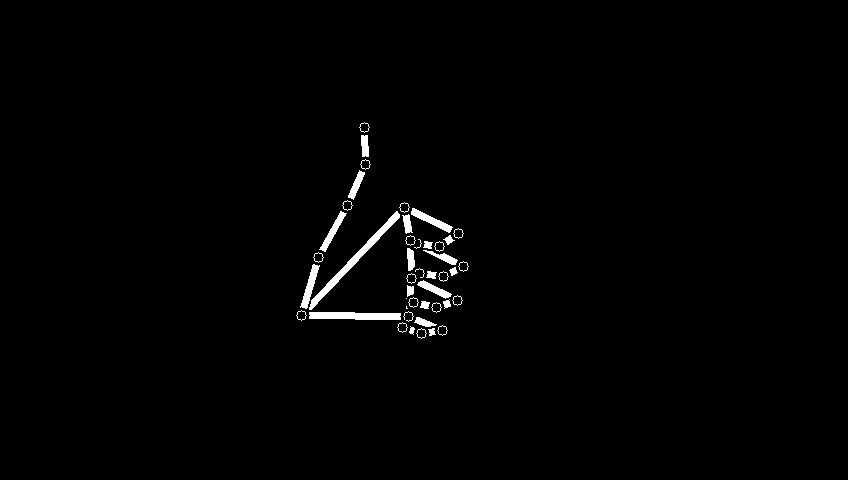

In [7]:
plot_hands(batch)

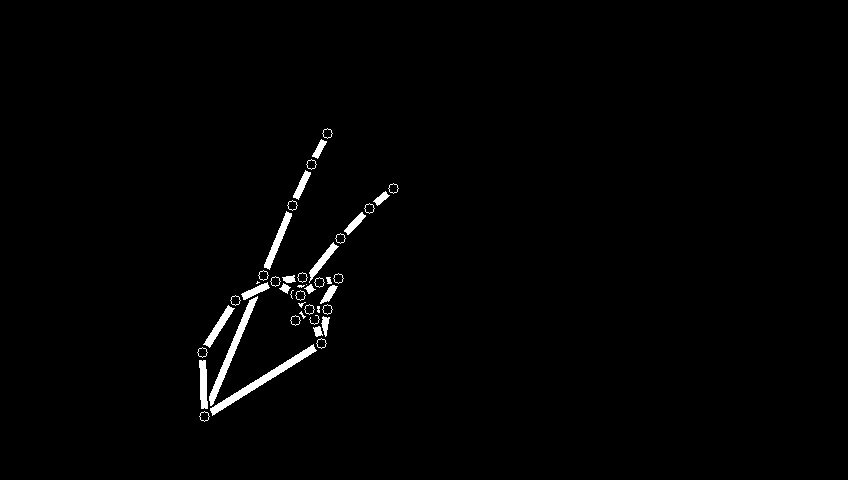

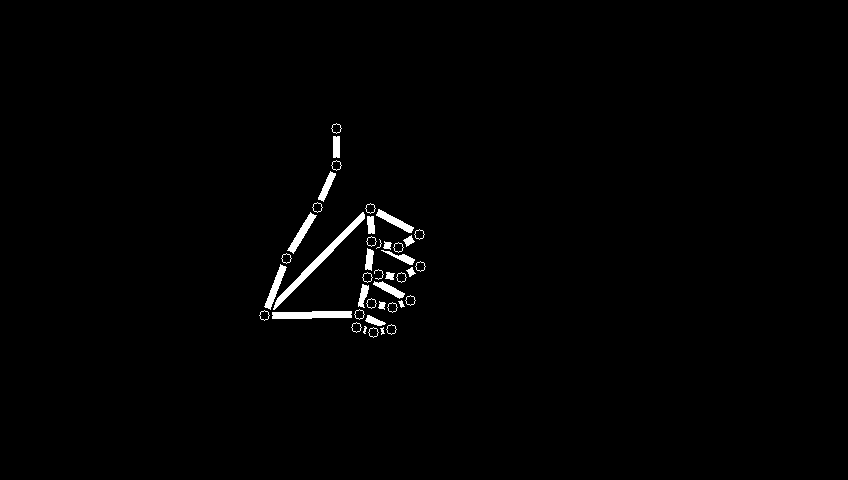

In [8]:
rot_batch = rotate_points(batch, 30)
plot_hands(rot_batch)

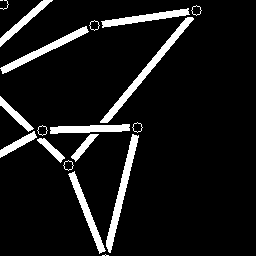

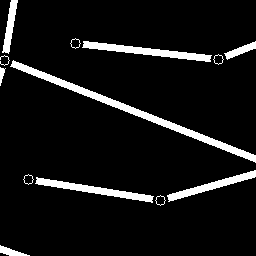

In [9]:
normalized_batch = normalize_landmarks(rot_batch)
plot_hands(normalized_batch, w=256, h=256)

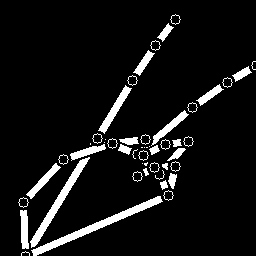

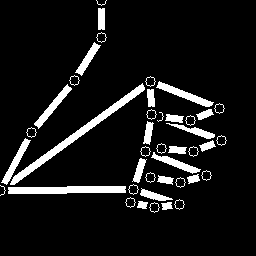

In [10]:
# interpolate values between 0 and 1 for plotting
def interpolate_landmarks(landmarks: torch.Tensor,) -> torch.Tensor:
    landmarks = landmarks.clone()
    landmarks[:, :, 0] = (landmarks[:, :, 0] - landmarks[:, :, 0].min()) / (landmarks[:, :, 0].max() - landmarks[:, :, 0].min())
    landmarks[:, :, 1] = (landmarks[:, :, 1] - landmarks[:, :, 1].min()) / (landmarks[:, :, 1].max() - landmarks[:, :, 1].min())
    return landmarks

interpolated_batch = interpolate_landmarks(normalized_batch)
plot_hands(interpolated_batch, w=256, h=256)

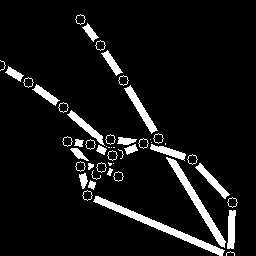

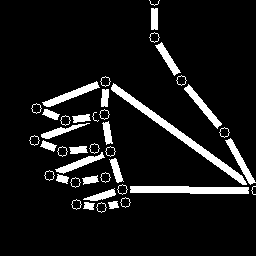

In [11]:
flipped_batch = horizontal_flip(normalized_batch)
interpolated_batch = interpolate_landmarks(flipped_batch)
plot_hands(interpolated_batch, w=256, h=256)

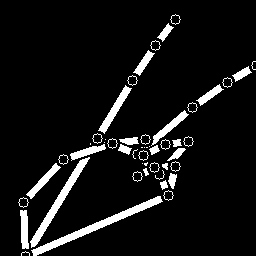

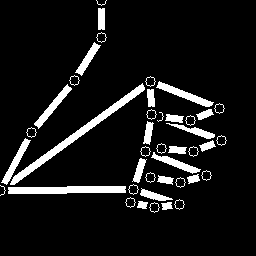

In [12]:
flipped_batch = depth_flip(normalized_batch)
interpolated_batch = interpolate_landmarks(flipped_batch)
plot_hands(interpolated_batch, w=256, h=256)